# Data Base Project - AskReddit Dataset Analysis

**Authors :**
- Emma BASTIEN
- Marie GOARDET 
- Nathan PIZZETTA

## Create Database Structure

Load Environment Variables and OracleDB Connection

In [4]:
import polars as pl
import os
import oracledb
from dotenv import load_dotenv, find_dotenv

load_dotenv(find_dotenv())

ORADB_PWD  = os.environ["ORADB_PWD"] 

OracleDB Connection

In [ ]:
# Change these parameters accordingly to match your needs
oradb_username = ""
oradb_password = ORADB_PWD
oradb_hostname = ""
oradb_port = ""
oradb_sid = ""

dsn = f"(DESCRIPTION=(ADDRESS=(PROTOCOL=TCP)(HOST={oradb_hostname})(PORT={oradb_port}))(CONNECT_DATA=(SID={oradb_sid})))"

oradb_connection = oracledb.connect(
    user=oradb_username,
    password=oradb_password,
    dsn=dsn
    )
oradb_cursor = oradb_connection.cursor()
print(oradb_connection)

<oracledb.Connection to SYSTEM@(DESCRIPTION=(ADDRESS=(PROTOCOL=TCP)(HOST=localhost)(PORT=1521))(CONNECT_DATA=(SID=FREE)))>

Table creation

In [ ]:
# Function to check if a table exists
def table_exists(table_name, cursor):
    query = f"SELECT COUNT(*) FROM USER_TABLES WHERE TABLE_NAME = UPPER('{table_name}')"
    cursor.execute(query)
    return cursor.fetchone()[0] > 0  # Returns True if table exists, False otherwise

statements = {
   "AUTHOR":
    """
        CREATE TABLE AUTHOR (
          author VARCHAR2(50) PRIMARY KEY
        )
    """,
    "DISTINGUISHED": 
    """
        CREATE TABLE DISTINGUISHED (
          distinguished VARCHAR2(50) PRIMARY KEY
        )
    """,
    "CONTROVERSY":
    """
        CREATE TABLE CONTROVERSY (
          controversiality NUMBER(1) PRIMARY KEY
        )
    """,
    "REMOVAL":
    """
        CREATE TABLE REMOVAL (
          removal_reason VARCHAR2(100) PRIMARY KEY
        )
    """,
    "SUBREDDIT":
    """
        CREATE TABLE SUBREDDIT (
          subreddit_id VARCHAR2(20) PRIMARY KEY,
          subreddit    VARCHAR2(100)
        )
    """,
    "PARENT":
    """
        CREATE TABLE PARENT (
          parent_id VARCHAR2(20) PRIMARY KEY,
          link_id   VARCHAR2(20)
        )
    """,
    "COMMENTS":
    """
        CREATE TABLE COMMENTS (
          id                      VARCHAR2(20) PRIMARY KEY,
          created_utc             NUMBER(19), 
          name                    VARCHAR2(50),
          body                    CLOB,
          edited                  NUMBER,
          author                  VARCHAR2(50),
          controversiality        NUMBER(1),
          subreddit_id            VARCHAR2(20),
          FOREIGN KEY (author) REFERENCES AUTHOR(author),
          FOREIGN KEY (controversiality) REFERENCES CONTROVERSY(controversiality),
          FOREIGN KEY (subreddit_id) REFERENCES SUBREDDIT(subreddit_id)
        )
    """,
    "SCORE":
    """
        CREATE TABLE SCORE (
          id           VARCHAR2(20) PRIMARY KEY,
          score        NUMBER,
          ups          NUMBER,
          downs        NUMBER,
          score_hidden NUMBER,
          gilded       NUMBER,
          FOREIGN KEY (id) REFERENCES COMMENTS(id)
        )
    """,
    "IS_DISTINGUISHED":
    """
        CREATE TABLE IS_DISTINGUISHED (
          id            VARCHAR2(20), 
          distinguished VARCHAR2(50),
          PRIMARY KEY (id, distinguished),
          FOREIGN KEY (id) REFERENCES COMMENTS(id),
          FOREIGN KEY (distinguished) REFERENCES DISTINGUISHED(distinguished)
        )
    """,
    "REMOVED":
    """
        CREATE TABLE REMOVED (
          id             VARCHAR2(20),
          removal_reason VARCHAR2(100),
          PRIMARY KEY(id, removal_reason), 
          FOREIGN KEY (id) REFERENCES COMMENTS(id),
          FOREIGN KEY (removal_reason) REFERENCES REMOVAL(removal_reason)
        )
    """,
    "DEPENDS":
    """
        CREATE TABLE DEPENDS (
          id         VARCHAR2(20),
          parent_id  VARCHAR2(20),
          PRIMARY KEY(id, parent_id),
          FOREIGN KEY (id) REFERENCES COMMENTS(id),
          FOREIGN KEY (parent_id) REFERENCES PARENT(parent_id)
        )
    """
}
    
for table_name, query in statements.items():
    if table_exists(table_name, oradb_cursor):
        print(f"Table '{table_name}' already exists. Skipping creation.")
    else:
        oradb_cursor.execute(query)
        print(f"Table created successfully.")

oradb_connection.commit()

Table created successfully.
Table created successfully.
Table created successfully.
Table created successfully.
Table created successfully.


## Load Data From CSV Files into Polar Dataframes

Load tables and check missing values

In [5]:
data_folder = "./data/csv_askreddit2015_split_dataset/"
dataframes = {}

# Check for nulls in all columns of each DataFrame
for table_csv in statements.keys():
    df_name = table_csv.lower()
    csv_file = os.path.join(data_folder, f"askreddit_{df_name}.csv")
    dataframes[df_name] = pl.read_csv(csv_file)
    df = dataframes[df_name]

    # Count missing values
    missing = df.select([col for col in df if col.null_count()>0]).null_count()

    # Print results with total number of rows
    print(f"Missing values in {table_csv}: {missing}")

Missing values in df_authors:
shape: (1, 0)
‚îå‚îê
‚ïû‚ï°
‚îî‚îò
Missing values in df_comments:
shape: (1, 2)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ author_flair_css_class ‚îÜ author_flair_text ‚îÇ
‚îÇ ---                    ‚îÜ ---               ‚îÇ
‚îÇ u32                    ‚îÜ u32               ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ 4234970                ‚îÜ 4234970           ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò
Missing values in df_controversy:
shape: (1, 0)
‚îå‚îê
‚ïû‚ï°
‚îî‚îò
Missing values in df_depends:
shape: (1, 0)
‚îå‚îê
‚ïû‚ï°
‚îî‚îò
Missing values in df_distinguished:
shape: (1, 1)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ distinguished ‚îÇ
‚îÇ

Handling missing values

In [ ]:
# Comments DataFrame
dataframes["comments"] = dataframes["comments"].drop(["author_flair_css_class", "author_flair_text"])

# Distinguished DataFrame
dataframes["distinguished"] = dataframes["distinguished"].with_columns([
    pl.col(c).fill_null("Not distinguished") for c in dataframes["distinguished"].columns
])

# Is_distinguished DataFrame
df_pandas = dataframes["is_distinguished"].to_pandas()['distinguished'].replace('', 'Not distinguished')
dataframes["is_distinguished"] = pl.from_pandas(df_pandas)

*Comment*<br>
Here we see that there are missing values in `df_distinguished` and in `df_comments`.<br>
- `df_comments`: we drop the two columns with missing values, ie `author_flair_css_class` and `author_flair_text` as there are only filled with `NaN`
- `df_distinguished`: we fill the missing value by "Not distinguished" by definition.
- `df_is_distinguished`: we fill the string "" by "Not distinguished".

Check the number of rows in the csv (loaded into the dataframes)

In [6]:
results = [(name, dataframes.height) for name, dataframes in dataframes.items()]

print(f"{'DataFrame':<15}{'Rows':<10}")
print('-' * 25)
for name, row_count in results:
    print(f"{name:<15}{row_count:<10}")

DataFrame      Rows      
-------------------------
authors        570735    
comments       4234970   
controversy    2         
depends        4234970   
distinguished  3         
is_distinguished4234970   
parent         1464558   
removal        1         
removed        0         
score          4234970   
subreddit      1         


## From dataframes to database

Function to write a DataFrame to an Oracle table

In [ ]:
def write_to_db_manually(df_in:pl.DataFrame, conn, table_name, batch_size=10):
    # Get a cursor
    cursor = conn.cursor()
    columns = ",".join(df_in.columns)
    col_idx = ",".join([f":{item}" for item in df_in.columns])
    sql     = f"INSERT INTO {table_name}({columns}) VALUES ({col_idx})"
    rows = df_in.to_struct().to_list()
    cursor.executemany(sql, rows)
    conn.commit()

Writing

In [ ]:
for name, df in dataframes.items():
    name = name.upper()
    try:
        write_to_db_manually(df, oradb_connection, name)
        print(f"Loaded {len(df)} rows into {name}.")
    except oracledb.DatabaseError as db_err:
        # Handle duplicates or existing data
        error_code = db_err.args[0].code if db_err.args else None
        print(f"DatabaseError on {name} (Code={error_code}): {db_err}")
        pass
    except Exception as e:
        # Catch any other error
        print(f"Unexpected error on {name}: {e}")
        pass

In [ ]:
dataframes["removed"]

shape: (0, 2)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ id  ‚îÜ  removal_reason ‚îÇ
‚îÇ --- ‚îÜ ---             ‚îÇ
‚îÇ str ‚îÜ str             ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

*Comment*<br>
No comments were removed in our analysis, that is why the table `REMOVED` is empty.

## Initial Database Exploration

### Overview

Describe the content of the database : what is inside each table

In [17]:
queries = [
"""
SELECT * 
FROM author 
FETCH FIRST 5 ROWS ONLY
""", 
"""
SELECT * 
FROM distinguished
""", 
"""
SELECT * 
FROM controversy
""", 
"""
SELECT * 
FROM removal
""", 
"""
SELECT * 
FROM subreddit
""",
"""
SELECT * 
FROM parent
FETCH FIRST 5 ROWS ONLY
""",
"""
SELECT * 
FROM comments
FETCH FIRST 5 ROWS ONLY
""",
"""
SELECT * 
FROM score
FETCH FIRST 5 ROWS ONLY
""",
"""
SELECT * 
FROM is_distinguished
FETCH FIRST 5 ROWS ONLY
""",
"""
SELECT * 
FROM depends
FETCH FIRST 5 ROWS ONLY
"""
]

results = {query.split()[3]: pl.read_database(query, oradb_cursor) for query in queries}

for table, df in results.items():
    print(f"\nTable: {table}")
    print(df)
    print("=" * 50) 


Table: author
shape: (5, 1)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ AUTHOR         ‚îÇ
‚îÇ ---            ‚îÇ
‚îÇ str            ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ jesse9o3       ‚îÇ
‚îÇ beltfedshooter ‚îÇ
‚îÇ InterimFatGuy  ‚îÇ
‚îÇ JuanTutrego    ‚îÇ
‚îÇ dcblackbelt    ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

Table: distinguished
shape: (3, 1)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ DISTINGUISHED     ‚îÇ
‚îÇ ---               ‚îÇ
‚îÇ str               ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ Not distinguished ‚îÇ
‚îÇ moderator         ‚îÇ
‚îÇ special           ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

Table: controversy
shape: (2, 1)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ CONTROVERSIALITY ‚îÇ
‚îÇ ---              ‚îÇ
‚îÇ i64              ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ 0  

Information about columns (name, datatypes...) of each table

In [ ]:
queries = [
    "SELECT column_name, data_type, nullable FROM all_tab_columns WHERE table_name = 'AUTHOR'",
    "SELECT column_name, data_type, nullable FROM all_tab_columns WHERE table_name = 'DISTINGUISHED'",
    "SELECT column_name, data_type, nullable FROM all_tab_columns WHERE table_name = 'CONTROVERSY'",
    "SELECT column_name, data_type, nullable FROM all_tab_columns WHERE table_name = 'REMOVAL'",
    "SELECT column_name, data_type, nullable FROM all_tab_columns WHERE table_name = 'SUBREDDIT'",
    "SELECT column_name, data_type, nullable FROM all_tab_columns WHERE table_name = 'PARENT'",
    "SELECT column_name, data_type, nullable FROM all_tab_columns WHERE table_name = 'COMMENTS'",
    "SELECT column_name, data_type, nullable FROM all_tab_columns WHERE table_name = 'SCORE'",
    "SELECT column_name, data_type, nullable FROM all_tab_columns WHERE table_name = 'IS_DISTINGUISHED'",
    "SELECT column_name, data_type, nullable FROM all_tab_columns WHERE table_name = 'DEPENDS'"
]

for query in queries:
    oradb_cursor.execute(query)  
    rows = oradb_cursor.fetchall()  
    table_name = query.split("table_name = '")[1].split("'")[0]  
    print(f"Description of {table_name} table:")
    for row in rows:
        print(f"Column: {row[0]}, Data Type: {row[1]}")
    print("=" * 50)  

Description of AUTHOR table:
Column: AUTHOR, Data Type: VARCHAR2
Description of DISTINGUISHED table:
Column: DISTINGUISHED, Data Type: VARCHAR2
Description of CONTROVERSY table:
Column: CONTROVERSIALITY, Data Type: NUMBER
Description of REMOVAL table:
Column: REMOVAL_REASON, Data Type: VARCHAR2
Description of SUBREDDIT table:
Column: SUBREDDIT_ID, Data Type: VARCHAR2
Column: SUBREDDIT, Data Type: VARCHAR2
Description of PARENT table:
Column: PARENT_ID, Data Type: VARCHAR2
Column: LINK_ID, Data Type: VARCHAR2
Description of COMMENTS table:
Column: ID, Data Type: VARCHAR2
Column: CREATED_UTC, Data Type: NUMBER
Column: NAME, Data Type: VARCHAR2
Column: BODY, Data Type: CLOB
Column: EDITED, Data Type: NUMBER
Column: AUTHOR, Data Type: VARCHAR2
Column: CONTROVERSIALITY, Data Type: NUMBER
Column: SUBREDDIT_ID, Data Type: VARCHAR2
Description of SCORE table:
Column: ID, Data Type: VARCHAR2
Column: SCORE, Data Type: NUMBER
Column: UPS, Data Type: NUMBER
Column: DOWNS, Data Type: NUMBER
Column:

Number of rows in each table

In [10]:
queries = [
    "SELECT COUNT(*) FROM author",
    "SELECT COUNT(*) FROM distinguished",
    "SELECT COUNT(*) FROM controversy",
    "SELECT COUNT(*) FROM removal",
    "SELECT COUNT(*) FROM removed",
    "SELECT COUNT(*) FROM subreddit",
    "SELECT COUNT(*) FROM parent",
    "SELECT COUNT(*) FROM comments",
    "SELECT COUNT(*) FROM score",
    "SELECT COUNT(*) FROM is_distinguished",
    "SELECT COUNT(*) FROM depends"
]

for query in queries:
    oradb_cursor.execute(query)  
    rows = oradb_cursor.fetchall() 
    print(f"Number of rows in {query.split()[3]}: {rows[0][0]}")

Number of rows in author: 570735
Number of rows in distinguished: 3
Number of rows in controversy: 2
Number of rows in removal: 1
Number of rows in removed: 0
Number of rows in subreddit: 1
Number of rows in parent: 1464558
Number of rows in comments: 4234970
Number of rows in score: 4234970
Number of rows in is_distinguished: 4234970
Number of rows in depends: 4234970


Number of comments per day in the AskReddit subreddit

In [78]:
query = """
SELECT
  TO_CHAR(DATE '1970-01-01' + NUMTODSINTERVAL(created_utc, 'SECOND'), 'YYYY-MM-DD') AS date_day,
  COUNT(*) AS nb_comments
FROM comments
GROUP BY TO_CHAR(DATE '1970-01-01' + NUMTODSINTERVAL(created_utc, 'SECOND'), 'YYYY-MM-DD')
ORDER BY date_day """
pl.read_database(query, oradb_cursor)

shape: (31, 2)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ DATE_DAY   ‚îÜ NB_COMMENTS ‚îÇ
‚îÇ ---        ‚îÜ ---         ‚îÇ
‚îÇ str        ‚îÜ i64         ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ 2015-05-01 ‚îÜ 141909      ‚îÇ
‚îÇ 2015-05-02 ‚îÜ 108746      ‚îÇ
‚îÇ 2015-05-03 ‚îÜ 104064      ‚îÇ
‚îÇ 2015-05-04 ‚îÜ 129515      ‚îÇ
‚îÇ 2015-05-05 ‚îÜ 148777      ‚îÇ
‚îÇ ‚Ä¶          ‚îÜ ‚Ä¶           ‚îÇ
‚îÇ 2015-05-27 ‚îÜ 138990      ‚îÇ
‚îÇ 2015-05-28 ‚îÜ 183461      ‚îÇ
‚îÇ 2015-05-29 ‚îÜ 186490      ‚îÇ
‚îÇ 2015-05-30 ‚îÜ 101148      ‚îÇ
‚îÇ 2015-05-31 ‚îÜ 129888      ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

### COMMENTS table

Top 5 commenters (5 authors that have commented the most in 2015 in the subreddit 'AskReddit')

In [20]:
query = """
SELECT a.author, COUNT(*) AS number_of_comments
FROM comments c
JOIN author a ON a.author = c.author
GROUP BY a.author
ORDER BY number_of_comments DESC
FETCH FIRST 5 ROWS ONLY
"""
pl.read_database(query, oradb_cursor)

shape: (5, 2)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ AUTHOR              ‚îÜ NUMBER_OF_COMMENTS ‚îÇ
‚îÇ ---                 ‚îÜ ---                ‚îÇ
‚îÇ str                 ‚îÜ i64                ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ [deleted]           ‚îÜ 312007             ‚îÇ
‚îÇ AutoModerator       ‚îÜ 36910              ‚îÇ
‚îÇ Late_Night_Grumbler ‚îÜ 8298               ‚îÇ
‚îÇ BiagioLargo         ‚îÜ 5843               ‚îÇ
‚îÇ -_-Equinox666-_-    ‚îÜ 2989               ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

*Comment*<br>

Here, we can see that the top 1 author corresponds to "[deleted]", which seems odd. We suspect that it could be an aggregation of all authors that posted during our period but who were deleted at some points.<br>

Also, the 2nd author that commented the most, "AutoModerator", if we inspect the body of its comment, seems to be a bot. All in all, to have better insights for our analysis on the real authors that commented, we exclude these two first authors. 

In [21]:
query = """
SELECT a.author, COUNT(*) AS number_of_comments
FROM comments c
JOIN author a ON a.author = c.author
GROUP BY a.author
ORDER BY number_of_comments DESC
OFFSET 2 ROWS FETCH NEXT 5 ROWS ONLY
"""
pl.read_database(query, oradb_cursor)

shape: (5, 2)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ AUTHOR              ‚îÜ NUMBER_OF_COMMENTS ‚îÇ
‚îÇ ---                 ‚îÜ ---                ‚îÇ
‚îÇ str                 ‚îÜ i64                ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ Late_Night_Grumbler ‚îÜ 8298               ‚îÇ
‚îÇ BiagioLargo         ‚îÜ 5843               ‚îÇ
‚îÇ -_-Equinox666-_-    ‚îÜ 2989               ‚îÇ
‚îÇ KubrickIsMyCopilot  ‚îÜ 2601               ‚îÇ
‚îÇ Megaross            ‚îÜ 2479               ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

Total number of controversial comments

In [22]:
query = """
SELECT COUNT(*) AS total_controversial_comments
FROM comments c
JOIN controversy co ON c.controversiality = co.controversiality
WHERE co.controversiality = 1
"""


oradb_cursor.execute(query)

row = oradb_cursor.fetchone()
print(f"Total number of controversial comments: {row[0]}")


Total number of controversial comments: 52218


Total number of edited comments

In [23]:
query = """
SELECT COUNT(*) AS number_of_edited_comments
FROM comments
WHERE edited > 0
"""

oradb_cursor.execute(query)

row = oradb_cursor.fetchone()
print(f"Total number of edited comments: {row[0]}")

Total number of edited comments: 80620


Top 2 commenters by number of comments distinguished as "special"

In [24]:
query = """
SELECT a.author, 
    COUNT(CASE WHEN d.distinguished = 'special' THEN 1 END) AS special_comments,
    COUNT(CASE WHEN d.distinguished = 'moderator' THEN 1 END) AS moderator_comments,
    COUNT(CASE WHEN d.distinguished = 'Not distinguished' THEN 1 END) AS not_distinguished_comments
FROM comments c
JOIN author a ON c.author = a.author
JOIN is_distinguished id ON c.id = id.id
JOIN distinguished d ON id.distinguished = d.distinguished
GROUP BY a.author
ORDER BY special_comments DESC
FETCH FIRST 2 ROWS ONLY
"""
pl.read_database(query, oradb_cursor)

shape: (2, 4)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ AUTHOR    ‚îÜ SPECIAL_COMMENTS ‚îÜ MODERATOR_COMMENTS ‚îÜ NOT_DISTINGUISHED_COMMENTS ‚îÇ
‚îÇ ---       ‚îÜ ---              ‚îÜ ---                ‚îÜ ---                        ‚îÇ
‚îÇ str       ‚îÜ i64              ‚îÜ i64                ‚îÜ i64                        ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ kn0thing  ‚îÜ 4                ‚îÜ 0                  ‚îÜ 11                         ‚îÇ
‚îÇ [deleted] ‚îÜ 0                ‚îÜ 0                  ‚îÜ 312007                     ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

*Comment*<br>

Only one author that have been writting comments distinguished as "special" !

Top 2 commenters by number of comments distinguished as "moderator"

In [25]:
query = """
SELECT a.author, 
    COUNT(CASE WHEN d.distinguished = 'special' THEN 1 END) AS special_comments,
    COUNT(CASE WHEN d.distinguished = 'moderator' THEN 1 END) AS moderator_comments,
    COUNT(CASE WHEN d.distinguished = 'Not distinguished' THEN 1 END) AS not_distinguished_comments
FROM comments c
JOIN author a ON c.author = a.author
JOIN is_distinguished id ON c.id = id.id
JOIN distinguished d ON id.distinguished = d.distinguished
GROUP BY a.author
ORDER BY moderator_comments DESC
FETCH FIRST 2 ROWS ONLY
"""
pl.read_database(query, oradb_cursor)

shape: (2, 4)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ AUTHOR        ‚îÜ SPECIAL_COMMENTS ‚îÜ MODERATOR_COMMENTS ‚îÜ NOT_DISTINGUISHED_COMMENTS ‚îÇ
‚îÇ ---           ‚îÜ ---              ‚îÜ ---                ‚îÜ ---                        ‚îÇ
‚îÇ str           ‚îÜ i64              ‚îÜ i64                ‚îÜ i64                        ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ AutoModerator ‚îÜ 0                ‚îÜ 36907              ‚îÜ 3                          ‚îÇ
‚îÇ GustavoFrings ‚îÜ 0                ‚îÜ 1691               ‚îÜ 562                        ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

Top 2 commenters "not distinguished"

In [29]:
query = """
SELECT a.author, 
    COUNT(CASE WHEN d.distinguished = 'special' THEN 1 END) AS special_comments,
    COUNT(CASE WHEN d.distinguished = 'moderator' THEN 1 END) AS moderator_comments,
    COUNT(CASE WHEN d.distinguished = 'Not distinguished' THEN 1 END) AS not_distinguished_comments
FROM comments c
JOIN author a ON c.author = a.author
JOIN is_distinguished id ON c.id = id.id
JOIN distinguished d ON id.distinguished = d.distinguished
GROUP BY a.author
ORDER BY not_distinguished_comments DESC
FETCH FIRST 2 ROWS ONLY
"""
pl.read_database(query, oradb_cursor)

shape: (2, 4)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ AUTHOR              ‚îÜ SPECIAL_COMMENTS ‚îÜ MODERATOR_COMMENTS ‚îÜ NOT_DISTINGUISHED_COMMENTS ‚îÇ
‚îÇ ---                 ‚îÜ ---              ‚îÜ ---                ‚îÜ ---                        ‚îÇ
‚îÇ str                 ‚îÜ i64              ‚îÜ i64                ‚îÜ i64                        ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ [deleted]           ‚îÜ 0                ‚îÜ 0                  ‚îÜ 312007                     ‚îÇ
‚îÇ Late_Night_Grumbler ‚îÜ 0                ‚îÜ 0                  ‚îÜ 8298                       ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

### SCORE table

*Comment*<br>

Visually, when investigating the dataframes, it seemed like the column downs was entirely filled with 0s, ie. meaning that apparently no thumbs down were given for all the comments we have at hand. Let us use a query to check this. 

In [88]:
query = """
SELECT
  SUM(downs) AS total_downvotes,
  CASE
    WHEN SUM(CASE WHEN downs != 0 THEN 1 ELSE 0 END) = 0 THEN 'All downs are zero'
    ELSE 'Some downs are not zero'
  END AS check_result
FROM SCORE 
"""
pl.read_database(query, oradb_cursor)

shape: (1, 2)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ TOTAL_DOWNVOTES ‚îÜ CHECK_RESULT       ‚îÇ
‚îÇ ---             ‚îÜ ---                ‚îÇ
‚îÇ i64             ‚îÜ str                ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ 0               ‚îÜ All downs are zero ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

*Comment*<br>

Now, we want to check if the score column corresponds exactly to the ups:

In [84]:
query = """ 
SELECT
  COUNT(*) AS total_rows,
  SUM(CASE WHEN score = ups THEN 1 ELSE 0 END) AS same_rows,
  SUM(CASE WHEN score != ups THEN 1 ELSE 0 END) AS different_rows
FROM SCORE
"""
pl.read_database(query, oradb_cursor)

shape: (1, 3)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ TOTAL_ROWS ‚îÜ SAME_ROWS ‚îÜ DIFFERENT_ROWS ‚îÇ
‚îÇ ---        ‚îÜ ---       ‚îÜ ---            ‚îÇ
‚îÇ i64        ‚îÜ i64       ‚îÜ i64            ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ 4234970    ‚îÜ 4234970   ‚îÜ 0              ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

*Comment*<br>

So, in the following of our analysis, we will not study the number of downs that were given since there are none and we will focus on the scores (which corresponds exactly to the number of ups)

Top 5 comments that scored the most (and if the score is hidden or not)

In [31]:
query = """
SELECT c.id, s.score, s.score_hidden
FROM score s
JOIN comments c on s.id = c.id
ORDER BY s.score DESC
FETCH FIRST 5 ROWS ONLY
"""
pl.read_database(query, oradb_cursor)

shape: (5, 3)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ ID      ‚îÜ SCORE ‚îÜ SCORE_HIDDEN ‚îÇ
‚îÇ ---     ‚îÜ ---   ‚îÜ ---          ‚îÇ
‚îÇ str     ‚îÜ i64   ‚îÜ i64          ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ cr56nez ‚îÜ 6761  ‚îÜ 0            ‚îÇ
‚îÇ cr5gn52 ‚îÜ 6736  ‚îÜ 0            ‚îÇ
‚îÇ cr3imvn ‚îÜ 5992  ‚îÜ 0            ‚îÇ
‚îÇ cr8p5z9 ‚îÜ 5927  ‚îÜ 0            ‚îÇ
‚îÇ cqxx3fj ‚îÜ 5849  ‚îÜ 0            ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

Top 5 authors with the highest karma in 2015 (sum of all comments' scores) / top 5 most active & influential

In [32]:
query = """
SELECT 
    a.author, 
    SUM(s.score) AS total_karma, 
    COUNT(c.id) AS total_comments, 
    ROUND(SUM(s.score) / COUNT(c.id), 2) AS average_karma
FROM comments c
JOIN author a ON c.author = a.author
JOIN score s ON c.id = s.id
GROUP BY a.author
ORDER BY total_karma DESC
FETCH FIRST 5 ROWS ONLY
"""
pl.read_database(query, oradb_cursor)

shape: (5, 4)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ AUTHOR          ‚îÜ TOTAL_KARMA ‚îÜ TOTAL_COMMENTS ‚îÜ AVERAGE_KARMA ‚îÇ
‚îÇ ---             ‚îÜ ---         ‚îÜ ---            ‚îÜ ---           ‚îÇ
‚îÇ str             ‚îÜ i64         ‚îÜ i64            ‚îÜ f64           ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ [deleted]       ‚îÜ 1353042     ‚îÜ 312007         ‚îÜ 4.34          ‚îÇ
‚îÇ Donald_Keyman   ‚îÜ 227175      ‚îÜ 312            ‚îÜ 728.13        ‚îÇ
‚îÇ kyle8998        ‚îÜ 100898      ‚îÜ 860            ‚îÜ 117.32        ‚îÇ
‚îÇ Naweezy         ‚îÜ 74654       ‚îÜ 69             ‚îÜ 1081.94       ‚îÇ
‚îÇ Irememberedmypw ‚îÜ 65769       ‚îÜ 895            ‚îÜ 73.48         ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

Top 5 authors with the highest average karma in 2015

In [33]:
query = """
SELECT 
    a.author, 
    SUM(s.score) AS total_karma, 
    COUNT(c.id) AS total_comments, 
    ROUND(SUM(s.score) / COUNT(c.id), 2) AS average_karma
FROM comments c
JOIN author a ON c.author = a.author
JOIN score s ON c.id = s.id
GROUP BY a.author
ORDER BY average_karma DESC
FETCH FIRST 5 ROWS ONLY
"""
pl.read_database(query, oradb_cursor)

shape: (5, 4)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ AUTHOR              ‚îÜ TOTAL_KARMA ‚îÜ TOTAL_COMMENTS ‚îÜ AVERAGE_KARMA ‚îÇ
‚îÇ ---                 ‚îÜ ---         ‚îÜ ---            ‚îÜ ---           ‚îÇ
‚îÇ str                 ‚îÜ i64         ‚îÜ i64            ‚îÜ i64           ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ lenaeca             ‚îÜ 5383        ‚îÜ 1              ‚îÜ 5383          ‚îÇ
‚îÇ CCorinne            ‚îÜ 4836        ‚îÜ 1              ‚îÜ 4836          ‚îÇ
‚îÇ The0isaZero         ‚îÜ 4834        ‚îÜ 1              ‚îÜ 4834          ‚îÇ
‚îÇ 4eyedoracle         ‚îÜ 4815        ‚îÜ 1              ‚îÜ 4815          ‚îÇ
‚îÇ planetoiletsscareme ‚îÜ 4755        ‚îÜ 1              ‚îÜ 4755          ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

Top 5 comments that received the most reddit gold (gilded)

In [58]:
query = """
SELECT 
    c.id, 
    s.score,
    SUM(s.gilded) AS gilded_count
FROM 
    comments c 
JOIN
    score s ON c.id = s.id
WHERE 
    gilded > 0  
GROUP BY 
    c.id, s.score
ORDER BY 
    gilded_count DESC
FETCH FIRST 5 ROWS ONLY
"""
pl.read_database(query, oradb_cursor)

shape: (5, 3)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ ID      ‚îÜ SCORE ‚îÜ GILDED_COUNT ‚îÇ
‚îÇ ---     ‚îÜ ---   ‚îÜ ---          ‚îÇ
‚îÇ str     ‚îÜ i64   ‚îÜ i64          ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ cr9xc7c ‚îÜ 4669  ‚îÜ 12           ‚îÇ
‚îÇ cr0ea66 ‚îÜ 5361  ‚îÜ 11           ‚îÇ
‚îÇ crfjkeh ‚îÜ 2227  ‚îÜ 9            ‚îÇ
‚îÇ crcvpys ‚îÜ 4735  ‚îÜ 8            ‚îÇ
‚îÇ cripwvz ‚îÜ 4595  ‚îÜ 7            ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

Top 5 authors that received the most reddit gold (on all 2015 comments posted)

In [35]:
query = """
SELECT 
    a.author, 
    SUM(s.gilded) AS total_gilded,
    COUNT(c.id) AS total_comments,
    ROUND(SUM(s.gilded) / COUNT(c.id), 2) AS average_nb_reddit_gold
FROM comments c
JOIN author a ON c.author = a.author
JOIN score s ON c.id = s.id
GROUP BY a.author
ORDER BY total_gilded DESC
FETCH FIRST 5 ROWS ONLY
"""
pl.read_database(query, oradb_cursor)

shape: (5, 4)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ AUTHOR              ‚îÜ TOTAL_GILDED ‚îÜ TOTAL_COMMENTS ‚îÜ AVERAGE_NB_REDDIT_GOLD ‚îÇ
‚îÇ ---                 ‚îÜ ---          ‚îÜ ---            ‚îÜ ---                    ‚îÇ
‚îÇ str                 ‚îÜ i64          ‚îÜ i64            ‚îÜ f64                    ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ Poem_for_your_sprog ‚îÜ 33           ‚îÜ 21             ‚îÜ 1.57                   ‚îÇ
‚îÇ Donald_Keyman       ‚îÜ 27           ‚îÜ 312            ‚îÜ 0.09                   ‚îÇ
‚îÇ springsoon          ‚îÜ 13           ‚îÜ 340            ‚îÜ 0.04                   ‚îÇ
‚îÇ [deleted]           ‚îÜ 12           ‚îÜ 312007         ‚îÜ 0.0                    ‚îÇ
‚îÇ kyle8998            ‚îÜ 12           ‚îÜ 860            ‚îÜ 0.01                   ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

In [36]:
query = """
SELECT 
    a.author, 
    SUM(s.gilded) AS total_gilded,
    COUNT(c.id) AS total_comments,
    ROUND(SUM(s.gilded) / COUNT(c.id), 2) AS average_nb_reddit_gold
FROM comments c
JOIN author a ON c.author = a.author
JOIN score s ON c.id = s.id
GROUP BY a.author
ORDER BY average_nb_reddit_gold DESC
FETCH FIRST 5 ROWS ONLY
"""
pl.read_database(query, oradb_cursor)

shape: (5, 4)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ AUTHOR              ‚îÜ TOTAL_GILDED ‚îÜ TOTAL_COMMENTS ‚îÜ AVERAGE_NB_REDDIT_GOLD ‚îÇ
‚îÇ ---                 ‚îÜ ---          ‚îÜ ---            ‚îÜ ---                    ‚îÇ
‚îÇ str                 ‚îÜ i64          ‚îÜ i64            ‚îÜ i64                    ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ GoldenScissors      ‚îÜ 7            ‚îÜ 1              ‚îÜ 7                      ‚îÇ
‚îÇ ionsevin            ‚îÜ 3            ‚îÜ 1              ‚îÜ 3                      ‚îÇ
‚îÇ Aquahawk911         ‚îÜ 4            ‚îÜ 2              ‚îÜ 2                      ‚îÇ
‚îÇ planetoiletsscareme ‚îÜ 2            ‚îÜ 1              ‚îÜ 2                      ‚îÇ
‚îÇ DaedricDanny        ‚îÜ 4            ‚îÜ 2              ‚îÜ 2                      ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

Top 5 most commented parent post as well as their average score associated

In [11]:
query = """ 
SELECT 
    p.parent_id,
    p.link_id, 
    COUNT(c.id) AS comment_count, 
    AVG(s.score) AS average_score
FROM COMMENTS c
JOIN DEPENDS d ON c.id = d.id
JOIN PARENT p ON d.parent_id = p.parent_id
JOIN SCORE s ON c.id = s.id
GROUP BY p.parent_id,  p.link_id
ORDER BY comment_count DESC
FETCH FIRST 5 ROWS ONLY
"""
pl.read_database(query, oradb_cursor)

shape: (5, 4)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ PARENT_ID ‚îÜ LINK_ID   ‚îÜ COMMENT_COUNT ‚îÜ AVERAGE_SCORE ‚îÇ
‚îÇ ---       ‚îÜ ---       ‚îÜ ---           ‚îÜ ---           ‚îÇ
‚îÇ str       ‚îÜ str       ‚îÜ i64           ‚îÜ f64           ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ t3_37pr7d ‚îÜ t3_37pr7d ‚îÜ 30771         ‚îÜ 2.699717      ‚îÇ
‚îÇ t3_37c2p3 ‚îÜ t3_37c2p3 ‚îÜ 11546         ‚îÜ 6.592759      ‚îÇ
‚îÇ t3_36ih74 ‚îÜ t3_36ih74 ‚îÜ 10981         ‚îÜ 11.933704     ‚îÇ
‚îÇ t3_365rlk ‚îÜ t3_365rlk ‚îÜ 7703          ‚îÜ 19.467091     ‚îÇ
‚îÇ t3_364iu2 ‚îÜ t3_364iu2 ‚îÜ 7558          ‚îÜ 6.954485      ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

Counting the number of controversial and non controversial comments as well as the average score and standard deviation of the score depending on if the comments are controversial or not

In [103]:
query = """
SELECT
  co.controversiality,
  COUNT(*) AS comment_count,
  AVG(s.score) AS average_score,
  STDDEV(s.score) AS std_dev
FROM COMMENTS c
JOIN CONTROVERSY co ON c.controversiality = co.controversiality
JOIN SCORE s ON c.id = s.id
GROUP BY co.controversiality
ORDER BY co.controversiality 
"""
pl.read_database(query, oradb_cursor)

shape: (2, 4)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ CONTROVERSIALITY ‚îÜ COMMENT_COUNT ‚îÜ AVERAGE_SCORE ‚îÜ STD_DEV    ‚îÇ
‚îÇ ---              ‚îÜ ---           ‚îÜ ---           ‚îÜ ---        ‚îÇ
‚îÇ i64              ‚îÜ i64           ‚îÜ f64           ‚îÜ f64        ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ 0                ‚îÜ 4182752       ‚îÜ 12.752865     ‚îÜ 125.273683 ‚îÇ
‚îÇ 1                ‚îÜ 52218         ‚îÜ 0.859991      ‚îÜ 13.047647  ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

Welch t-test of mean comparison between mean score of controversial vs mean score of non controversial comments

In [ ]:
query = """
WITH stats AS (
  SELECT
    ctr.controversiality,
    COUNT(*) AS n,
    AVG(s.score) AS mean,
    STDDEV(s.score) AS stddev
  FROM COMMENTS c
  JOIN CONTROVERSY ctr ON c.controversiality = ctr.controversiality
  JOIN SCORE s ON c.id = s.id
  GROUP BY ctr.controversiality
),
welch_test AS (
  SELECT
    a.n AS n1,
    b.n AS n2,
    a.mean AS mean1,
    b.mean AS mean2,
    a.stddev AS sd1,
    b.stddev AS sd2,
    (a.mean - b.mean) AS diff_means,
    
    SQRT(POWER(a.stddev, 2)/a.n + POWER(b.stddev, 2)/b.n) AS std_error,
    
    -- t-statistic
    (a.mean - b.mean) / SQRT(POWER(a.stddev, 2)/a.n + POWER(b.stddev, 2)/b.n) AS t_statistic,

    -- Degrees of freedom (Welch-Satterthwaite)
    POWER((POWER(a.stddev, 2)/a.n + POWER(b.stddev, 2)/b.n), 2) /
    (
      (POWER(POWER(a.stddev, 2)/a.n, 2)) / (a.n - 1) +
      (POWER(POWER(b.stddev, 2)/b.n, 2)) / (b.n - 1)
    ) AS degrees_freedom

  FROM stats a
  JOIN stats b ON a.controversiality = 1 AND b.controversiality = 0
)
SELECT
  diff_means,
  std_error,
  t_statistic,
  degrees_freedom
FROM welch_test
"""
pl.read_database(query, oradb_cursor)


shape: (1, 4)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ DIFF_MEANS ‚îÜ STD_ERROR ‚îÜ T_STATISTIC ‚îÜ DEGREES_FREEDOM ‚îÇ
‚îÇ ---        ‚îÜ ---       ‚îÜ ---         ‚îÜ ---             ‚îÇ
‚îÇ f64        ‚îÜ f64       ‚îÜ f64         ‚îÜ f64             ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ -11.892874 ‚îÜ 0.083739  ‚îÜ -142.023791 ‚îÜ 237631.813243   ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

*Comment*<br>

A Welch‚Äôs t-test was conducted to compare the average score of controversial (controversiality = 1) and non-controversial (controversiality = 0) comments.
The test yielded a t-statistic of -142 with 237,631 degrees of freedom.
This result is highly statistically significant (p < 0.0001), indicating a very strong difference in the average score between¬†the¬†two¬†groups.

## Advanced Analysis - Focus on a specific post <br>"High schoolers, what do you want to major in ? People who majored in that field, what are the pros and cons ?"<br>

Url : https://www.reddit.com/r/AskReddit/comments/37c2p3/high_schoolers_what_do_you_want_to_major_in/ <br>

*Comment* : Here we work one one hand for more advanced queries with SQL and on the other hand for text analysis with pandas.<br>

To select this post we first looked at the most commented posts and then we selected the second one because of our interest on the content of the post.

In [40]:
# Transform dataframe from polars to pandas
pd_dataframes = {}

for table in dataframes.keys():
    pd_dataframes[table] = dataframes[table].to_pandas()

In [41]:
depends = pd_dataframes["depends"]
depends_ordered = depends.groupby("parent_id").count().sort_values("id", ascending=False)
job_dream_com_ids = depends[depends["parent_id"] == "t3_37c2p3"]["id"].to_list()
depends_ordered.head(2)

id
parent_id       
t3_37pr7d  30771
t3_37c2p3  11546

In [42]:
# Get the comments for the job_dream_com_ids
comments = pd_dataframes["comments"]
job_dream_com = comments[comments["id"].isin(job_dream_com_ids)]

# Drop deleted comments
job_dream_com = job_dream_com[job_dream_com["body"] != "[deleted]"]

# We show the first 10 comments
job_dream_com["body"].to_list()[:10]

["Accounting, I've always heard it's a safe bet\n\nThanks for the info everyone ",
 'Computer Science',
 'Some combination of electrical/computer engineering, computer science, and either philosophy/econ/Chinese',
 'In highschool I wanted to major in Computer Science, and now that I\'m in college, I\'m working with pre-law.\n\nEDIT: Looks like I need to reevaluate my classes that I signed up to be in for the Fall Semester. For the record, I am terrible at math, and that was a large variable in ditching CS.\n\nEDIT 2: Mislabeled myself. Not majoring in a dedicated "Pre-Law" course branch, I\'m really just double majoring in Criminal Justice and Philosophy.\n\n\nThanks for the input, everyone. I\'ve only just begun college, going into my second year soon. I think I still need to see where I can go.',
 "Hey! I've been thinking about a lot of choices i could possibly be majoring in. My mother say i should focus on just a few.\nRight now, i've been thinking about applying for history, chine

### SQL

Creation of the Subset in SQL

In [ ]:
query = """ 
CREATE MATERIALIZED VIEW parent_post_subset AS
SELECT parent_id, link_id
FROM PARENT
WHERE link_id = 't3_37c2p3' 
AND parent_id = 't3_37c2p3'
"""

oradb_cursor.execute(query)
oradb_cursor.connection.commit()

Top 10 Most Upvoted (comments in the subset)

In [ ]:
query = """
SELECT 
    c.id, 
    c.body, 
    s.score
FROM 
    score s
JOIN 
    comments c ON s.id = c.id
JOIN 
    depends d ON c.id = d.id  
JOIN 
    parent_post_subset pps ON d.parent_id = pps.parent_id  
ORDER BY 
    s.score DESC
FETCH FIRST 10 ROWS ONLY
"""
pl.read_database(query, oradb_cursor)

shape: (10, 3)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ ID      ‚îÜ BODY                            ‚îÜ SCORE ‚îÇ
‚îÇ ---     ‚îÜ ---                             ‚îÜ ---   ‚îÇ
‚îÇ str     ‚îÜ object                          ‚îÜ i64   ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ crlfb88 ‚îÜ Theatre major here. Just remem‚Ä¶ ‚îÜ 4579  ‚îÇ
‚îÇ crle0cg ‚îÜ Ctrl + F for chemistry.         ‚îÜ 4339  ‚îÇ
‚îÇ         ‚îÜ                                 ‚îÜ       ‚îÇ
‚îÇ         ‚îÜ 0 re‚Ä¶                           ‚îÜ       ‚îÇ
‚îÇ crlgfr9 ‚îÜ I just wanna bring to the atte‚Ä¶ ‚îÜ 4190  ‚îÇ
‚îÇ crlddy3 ‚îÜ Computer Science                ‚îÜ 3427  ‚îÇ
‚îÇ crldea1 ‚îÜ [deleted]                       ‚îÜ 3067  ‚îÇ
‚îÇ crlf7ys ‚îÜ ITT: My hopes and dreams being‚Ä¶ ‚îÜ 2927  ‚îÇ
‚îÇ crlf5j9 ‚îÜ Just gonna jump in and say reg‚Ä¶ ‚îÜ 2468  ‚îÇ
‚îÇ crleeef ‚îÜ Mechanical Engineering          ‚îÜ 2184  ‚îÇ
‚îÇ         ‚îÜ                                 ‚îÜ       ‚îÇ
‚îÇ         ‚îÜ edit: ‚Ä¶                         ‚îÜ       ‚îÇ
‚îÇ crlem5l ‚îÜ Cosmolgy/Astrophysics!          ‚îÜ 1941  ‚îÇ
‚îÇ         ‚îÜ                                 ‚îÜ       ‚îÇ
‚îÇ         ‚îÜ edit:‚Ä¶                          ‚îÜ       ‚îÇ
‚îÇ crlf3fi ‚îÜ College student here to addres‚Ä¶ ‚îÜ 1932  ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

Top 10 Most Controversial (comments in the subset)

In [32]:
query = """
SELECT 
    c.id, 
    c.body, 
    s.score, 
    s.gilded, 
    co.controversiality 
FROM 
    score s
JOIN 
    comments c ON s.id = c.id
JOIN 
    depends d ON c.id = d.id 
JOIN 
    parent_post_subset pps ON d.parent_id = pps.parent_id 
JOIN 
    controversy co ON c.controversiality = co.controversiality  
WHERE 
    co.controversiality = 1 
ORDER BY 
    s.score ASC
FETCH FIRST 10 ROWS ONLY
"""
pl.read_database(query, oradb_cursor)

shape: (10, 5)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ ID      ‚îÜ BODY                            ‚îÜ SCORE ‚îÜ GILDED ‚îÜ CONTROVERSIALITY ‚îÇ
‚îÇ ---     ‚îÜ ---                             ‚îÜ ---   ‚îÜ ---    ‚îÜ ---              ‚îÇ
‚îÇ str     ‚îÜ object                          ‚îÜ i64   ‚îÜ i64    ‚îÜ i64              ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ crle6qj ‚îÜ High schoolers?!?! STOP. I did‚Ä¶ ‚îÜ -11   ‚îÜ 0      ‚îÜ 1                ‚îÇ
‚îÇ crlg0ie ‚îÜ I'm surprised I haven't seen m‚Ä¶ ‚îÜ -5    ‚îÜ 0      ‚îÜ 1                ‚îÇ
‚îÇ crlgpxp ‚îÜ Basket Weaving. I hear it's wh‚Ä¶ ‚îÜ -4    ‚îÜ 0      ‚îÜ 1                ‚îÇ
‚îÇ crlgvlf ‚îÜ Napping. I feel that it is a r‚Ä¶ ‚îÜ -3    ‚îÜ 0      ‚îÜ 1                ‚îÇ
‚îÇ crlne7e ‚îÜ Dank Memes                      ‚îÜ -3    ‚îÜ 0      ‚îÜ 1                ‚îÇ
‚îÇ crlmei7 ‚îÜ Pussy                           ‚îÜ -2    ‚îÜ 0      ‚îÜ 1                ‚îÇ
‚îÇ crlhhid ‚îÜ Can I major in telling people ‚Ä¶ ‚îÜ -1    ‚îÜ 0      ‚îÜ 1                ‚îÇ
‚îÇ crlvfkr ‚îÜ Currently in Grade 10, I was t‚Ä¶ ‚îÜ -1    ‚îÜ 0      ‚îÜ 1                ‚îÇ
‚îÇ crm1lod ‚îÜ Explosive engineering? Anybody‚Ä¶ ‚îÜ 0     ‚îÜ 0      ‚îÜ 1                ‚îÇ
‚îÇ crlquz3 ‚îÜ Ctrl + F "English"              ‚îÜ 1     ‚îÜ 0      ‚îÜ 1                ‚îÇ
‚îÇ         ‚îÜ                                 ‚îÜ       ‚îÜ        ‚îÜ                  ‚îÇ
‚îÇ         ‚îÜ Nothing. S‚Ä¶                     ‚îÜ       ‚îÜ        ‚îÜ                  ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

Top 10 Most Gilded (comments in the subset)

In [27]:
query = """ 
SELECT 
    c.id, 
    c.body, 
    s.score, 
    s.gilded
FROM 
    score s
JOIN 
    comments c ON s.id = c.id
JOIN 
    depends d ON c.id = d.id  
JOIN 
    parent_post_subset pps ON d.parent_id = pps.parent_id 
WHERE 
    s.gilded > 0 
ORDER BY 
    s.gilded DESC, s.score DESC
"""

pl.read_database(query, oradb_cursor)

shape: (5, 4)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ ID      ‚îÜ BODY                            ‚îÜ SCORE ‚îÜ GILDED ‚îÇ
‚îÇ ---     ‚îÜ ---                             ‚îÜ ---   ‚îÜ ---    ‚îÇ
‚îÇ str     ‚îÜ object                          ‚îÜ i64   ‚îÜ i64    ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ crlgfr9 ‚îÜ I just wanna bring to the atte‚Ä¶ ‚îÜ 4190  ‚îÜ 1      ‚îÇ
‚îÇ crlf5j9 ‚îÜ Just gonna jump in and say reg‚Ä¶ ‚îÜ 2468  ‚îÜ 1      ‚îÇ
‚îÇ crlfkan ‚îÜ Electrical Engineering üòÉ       ‚îÜ 539   ‚îÜ 1      ‚îÇ
‚îÇ         ‚îÜ Edit:‚Ä¶                          ‚îÜ       ‚îÜ        ‚îÇ
‚îÇ crlgoy0 ‚îÜ Just throwing this out there f‚Ä¶ ‚îÜ 453   ‚îÜ 1      ‚îÇ
‚îÇ crlegpw ‚îÜ High school students, I recomm‚Ä¶ ‚îÜ 205   ‚îÜ 1      ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

Top 10 Most Influential Authors (in the subset)

In [28]:
query = """ 
SELECT 
    c.author, 
    COUNT(c.id) AS num_comments, 
    SUM(s.score) AS total_score
FROM 
    score s
JOIN 
    comments c ON s.id = c.id
JOIN 
    depends d ON c.id = d.id  
JOIN 
    parent_post_subset pps ON d.parent_id = pps.parent_id  
GROUP BY 
    c.author
ORDER BY 
    total_score DESC  
FETCH FIRST 10 ROWS ONLY
"""

pl.read_database(query, oradb_cursor)

shape: (10, 3)
‚îå‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¨‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îê
‚îÇ AUTHOR              ‚îÜ NUM_COMMENTS ‚îÜ TOTAL_SCORE ‚îÇ
‚îÇ ---                 ‚îÜ ---          ‚îÜ ---         ‚îÇ
‚îÇ str                 ‚îÜ i64          ‚îÜ i64         ‚îÇ
‚ïû‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï™‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ïê‚ï°
‚îÇ GregoryPippenbottom ‚îÜ 1            ‚îÜ 4579        ‚îÇ
‚îÇ langis_on           ‚îÜ 1            ‚îÜ 4339        ‚îÇ
‚îÇ Lostlittlebunny     ‚îÜ 1            ‚îÜ 4190        ‚îÇ
‚îÇ [deleted]           ‚îÜ 719          ‚îÜ 3845        ‚îÇ
‚îÇ geoffisblind        ‚îÜ 1            ‚îÜ 3427        ‚îÇ
‚îÇ Final_Hour          ‚îÜ 2            ‚îÜ 3265        ‚îÇ
‚îÇ zaj209              ‚îÜ 1            ‚îÜ 2468        ‚îÇ
‚îÇ Panzer6             ‚îÜ 1            ‚îÜ 2184        ‚îÇ
‚îÇ Ohrianna            ‚îÜ 1            ‚îÜ 1941        ‚îÇ
‚îÇ AlekRivard          ‚îÜ 1            ‚îÜ 1932        ‚îÇ
‚îî‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚î¥‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îÄ‚îò

### Python<br>

Uncomment to install the required dependencies.

In [ ]:
#!pip install wordcloud spacy textblob
#!python -m spacy download en_core_web_sm

In [70]:
import nltk
import spacy
import re
from collections import Counter
from textblob import TextBlob
from nltk.corpus import stopwords
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import word_tokenize



# Download required NLTK resources
nltk.download("stopwords")
nltk.download("punkt")
nltk.download('punkt_tab')

# Load spaCy English model
nlp = spacy.load("en_core_web_sm")

import en_core_web_sm
nlp = en_core_web_sm.load()

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/nathanpizzetta/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/nathanpizzetta/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/nathanpizzetta/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


#### Word Frequency Analysis

Functions and preprocessing

In [80]:
# Preprocess text: remove punctuation, stopwords
stop_words = set(stopwords.words("english"))

def preprocess_text(text):
    text = re.sub(r'\W', ' ', text)  # Remove punctuation
    text = text.lower()  # Convert to lowercase
    words = word_tokenize(text)  # Tokenize
    words = [word for word in words if word not in stop_words and len(word) > 2]  # Remove stopwords
    return words

def preprocess_text_v2(text):
    """
    Preprocess text:
    - Remove punctuation
    - Convert to lowercase
    - Extract only nouns using spaCy
    - Remove stopwords and short words (less than 3 letters)
    """
    text = re.sub(r'\W', ' ', text)  # Remove punctuation
    text = text.lower().strip()  # Convert to lowercase and strip whitespace
    
    # Process text with spaCy
    doc = nlp(text)
    
    # Extract only nouns
    words = [token.text for token in doc if token.pos_ == "NOUN" and token.text not in stop_words and len(token.text) > 2]
    
    return words


# Apply preprocessing
job_dream_com["processed_text"] = job_dream_com["body"].apply(preprocess_text_v2)
job_dream_com["processed_text2"] = job_dream_com["body"].apply(preprocess_text)

# Flatten all words into a list
all_words = [word for words in job_dream_com["processed_text"] for word in words]
all_words2 = [word for words in job_dream_com["processed_text2"] for word in words]

# Count the most common words
word_freq = Counter(all_words)
word_freq2 = Counter(all_words2)

# Display top 20 words
print(word_freq.most_common(20))
print(word_freq2.most_common(20))

[('engineering', 1876), ('science', 1214), ('school', 971), ('computer', 924), ('business', 591), ('job', 563), ('college', 562), ('major', 487), ('degree', 481), ('biology', 480), ('field', 473), ('year', 410), ('design', 407), ('people', 398), ('music', 387), ('management', 327), ('law', 311), ('psychology', 304), ('finance', 296), ('work', 289)]
[('engineering', 1936), ('want', 1434), ('major', 1400), ('science', 1221), ('school', 977), ('computer', 927), ('like', 874), ('get', 745), ('would', 644), ('business', 628), ('know', 628), ('really', 620), ('work', 616), ('college', 571), ('going', 569), ('job', 563), ('high', 524), ('degree', 485), ('biology', 481), ('field', 473)]


*Comment*<br>

We can see from both approaches with nouns and verbs that words like "engineering", "science", "school" or "computer" are frequent in our subset.

Only nouns.

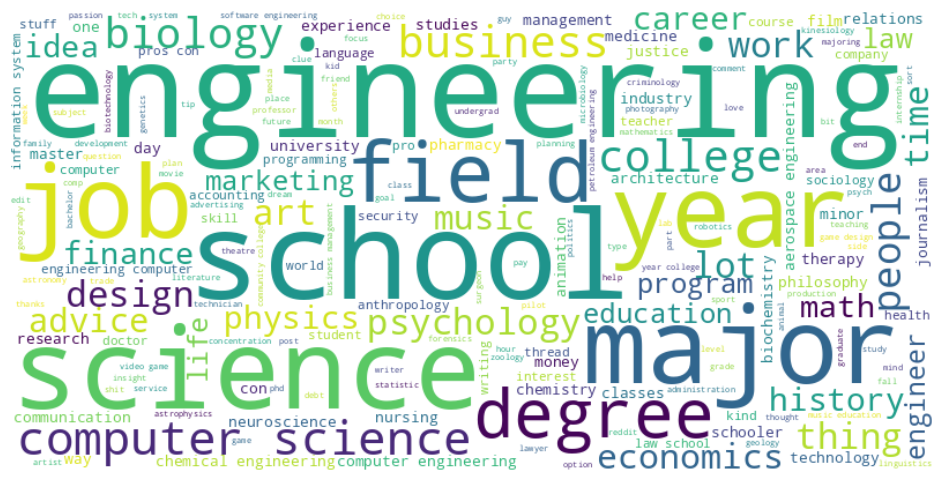

In [77]:
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(" ".join(all_words))

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

Nouns, verbs, adjectives.

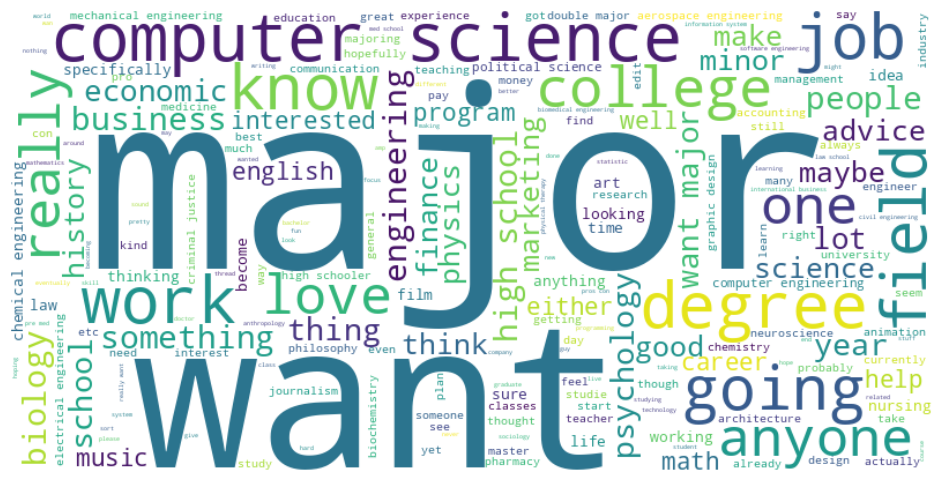

In [81]:
wordcloud2 = WordCloud(width=800, height=400, background_color="white").generate(" ".join(all_words2))

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud2, interpolation="bilinear")
plt.axis("off")
plt.show()

#### Sentiment Analysis


Most Positive Comments:
                                                      body  sentiment
3419515  Industrial engineering. Basically I like busin...        1.0
3430195  Aerospace/aeronautical engineering\nAnyone got...        1.0
3434892                                     Kinesiology :D        1.0
3435908  Computer Science (software engineering honours...        1.0
3435973  Aeronautical Science, I want to be a pilot so ...        1.0

Most Negative Comments:
                                                      body  sentiment
3465283     Dentistry. I've heard terrible things from it.    -1.0000
3497217  pros of linguistics: (almost) no essays or pap...    -1.0000
3592894  Seriously don't ask me that question!! I don't...    -1.0000
3462089  Electrical engineering, or civil. I really hat...    -0.9000
3493817                 No Finance? I'm useless again! :'(    -0.8125


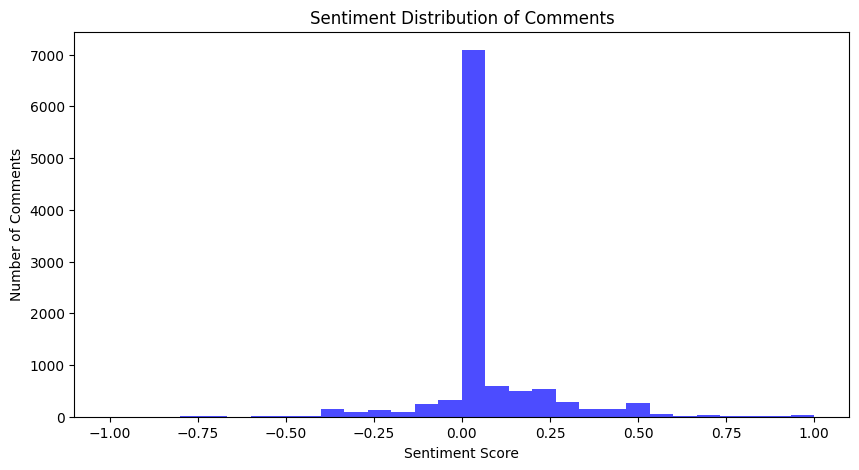

In [74]:
def get_sentiment(text):
    return TextBlob(text).sentiment.polarity  # Returns a score from -1 to 1

# Apply sentiment analysis
job_dream_com["sentiment"] = job_dream_com["body"].apply(get_sentiment)

# Display top positive and negative comments
print("\nMost Positive Comments:")
print(job_dream_com.nlargest(5, "sentiment")[["body", "sentiment"]])

print("\nMost Negative Comments:")
print(job_dream_com.nsmallest(5, "sentiment")[["body", "sentiment"]])

# Plot sentiment distribution
plt.figure(figsize=(10,5))
plt.hist(job_dream_com["sentiment"], bins=30, color="blue", alpha=0.7)
plt.xlabel("Sentiment Score")
plt.ylabel("Number of Comments")
plt.title("Sentiment Distribution of Comments")
plt.show()

#### Named Entity Recognition (NER)

In [75]:
def extract_entities(text):
    doc = nlp(text)
    return [ent.text for ent in doc.ents if ent.label_ in ["ORG", "PERSON", "GPE", "NORP"]]

job_dream_com["entities"] = job_dream_com["body"].apply(extract_entities)

# Display most mentioned entities
entity_counts = Counter([ent for ents in job_dream_com["entities"] for ent in ents])
print("\nMost Mentioned Entities:")
print(entity_counts.most_common(10))


Most Mentioned Entities:
[('Chemical Engineering', 81), ('Computer Engineering', 72), ('Chemical', 62), ('Pros', 62), ('Aerospace Engineering', 60), ('Mechanical Engineering', 51), ('CS', 47), ('Biomedical Engineering', 45), ('Neuroscience', 42), ('Computer Science', 41)]


#### Topic Modelling with Bigram Analysis

In [78]:
vectorizer = CountVectorizer(ngram_range=(2, 2), stop_words="english")
X = vectorizer.fit_transform(job_dream_com["body"])

# Get most common bigrams
bigrams = dict(zip(vectorizer.get_feature_names_out(), X.sum(axis=0).tolist()[0]))

# Sort and display top bigrams
sorted_bigrams = sorted(bigrams.items(), key=lambda x: x[1], reverse=True)
print("\nMost Common Bigrams (Two-Word Phrases):")
print(sorted_bigrams[:10])


Most Common Bigrams (Two-Word Phrases):
[('computer science', 511), ('high school', 342), ('want major', 253), ('don know', 174), ('chemical engineering', 173), ('computer engineering', 166), ('political science', 165), ('aerospace engineering', 163), ('mechanical engineering', 152), ('electrical engineering', 143)]


#### Compare Sentiment Scores Between Majors

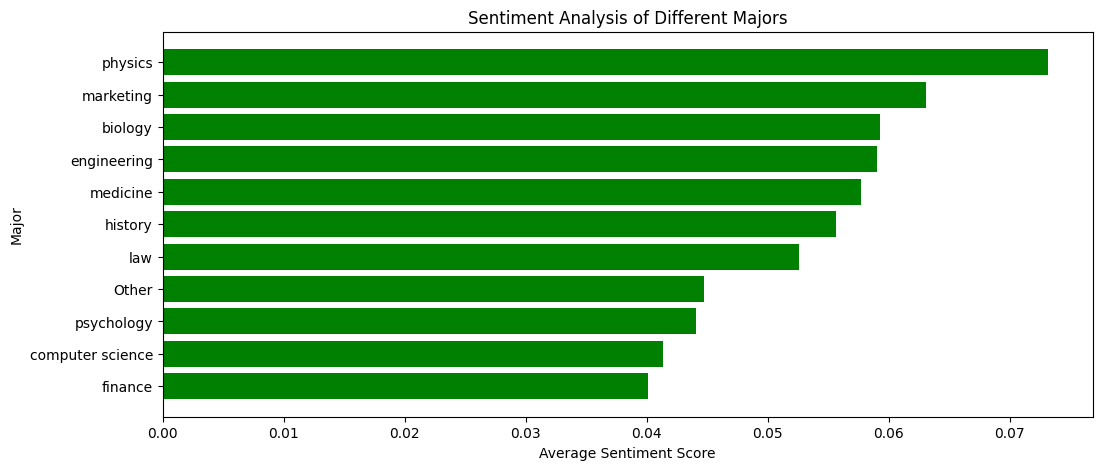

In [79]:
# Extract major fields using regex
majors_list = ["computer science", "engineering", "biology", "finance", "law", "medicine", "physics", "psychology", "marketing", "history"]

def get_major(text):
    for major in majors_list:
        if major in text.lower():
            return major
    return "Other"

job_dream_com["major"] = job_dream_com["body"].apply(get_major)

# Calculate average sentiment per major
major_sentiments = job_dream_com.groupby("major")["sentiment"].mean().sort_values()

# Plot the results
plt.figure(figsize=(12, 5))
plt.barh(major_sentiments.index, major_sentiments.values, color="green")
plt.xlabel("Average Sentiment Score")
plt.ylabel("Major")
plt.title("Sentiment Analysis of Different Majors")
plt.show()


## Subset Creation (Database less than 5MB)

In [88]:
# Estimate the MB of the data job_dream_com
print("Estimated memory usage of our sample:", round(job_dream_com.memory_usage(deep=True).sum() / 1024 / 1024, 2), "MB")

Estimated memory usage of our sample: 4.71 MB


## Bonus : A Poem for your conveniance<br>

It comes from one of the most gilded author of our dataset : "Poem_for_your_sprog"

In [ ]:
import markdown
from IPython.display import display, HTML

poem = comments[comments["id"] == "cqy3sp9"]["body"].to_list()[0]
display(HTML(markdown.markdown(poem)))

This one was the second most gilded of his comments

In [40]:
# Show the scores on descending order for gilded
score = pd_dataframes["score"]
poem_com = comments[comments["author"] == "Poem_for_your_sprog"]
poem_com_ids = poem_com["id"].to_list()
score[score["id"].isin(poem_com_ids)].sort_values("gilded", ascending=False)

id  score   ups  downs  score_hidden  gilded
743386   cr0ea66   5361  5361      0             0      11
437414   cqy3sp9   2599  2599      0             0       5
1681957  cr7urra   5345  5345      0             0       3
2085673  crb09rp   4850  4850      0             0       2
2484956  cre32ur   3859  3859      0             0       2
3903830  crou015   1707  1707      0             0       1
3752744  crnugu5   3293  3293      0             0       1
3572552  crmiym4   4309  4309      0             0       1
3286963  crkbtsk   1116  1116      0             0       1
2790009  crgfude   2197  2197      0             0       1
193679   cqw0599    947   947      0             0       1
309037   cqwxzag    806   806      0             0       1
1498847  cr6htom   2790  2790      0             0       1
1263784  cr4gonj   2974  2974      0             0       1
1055769  cr2nxuy   3840  3840      0             0       1
2345525  crcxdbw   1284  1284      0             0       0
2808390  crgket4   2180  2180      0             0       0
1265745  cr4hb8c   2222  2222      0             0       0
3421693  crlfok5   1686  1686      0             0       0
321046   cqx2dt5    902   902      0             0       0
4182900  crqunkf   1237  1237      0             0       0